In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from shutil import copyfile
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

## Data Download

In [18]:
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"yurun1208","key":"9eaf531858876d727f984d4dd76825a5"}' >> kaggle.json # kaggle.json from kaggle account API

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [19]:
!rm -rf ~/.kaggle/kaggle.json
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download ikarus777/best-artworks-of-all-time
!unzip -qq best-artworks-of-all-time.zip

100% 2.28G/2.29G [00:24<00:00, 205MB/s]
100% 2.29G/2.29G [00:25<00:00, 98.3MB/s]


## Data Preprocess

In [20]:
# artist_names = ['Edgar Degas']
num_artists = 4

artist_df = pd.read_csv('./artists.csv')
artist_df = artist_df.sort_values(by='paintings', ascending=False)
artist_df = artist_df.iloc[:num_artists]
# artist_df = artist_df[artist_df['name'].isin(artist_names)]
artist_list = artist_df['name'].str.replace(' ', '_').tolist()
artist_dict = {}
for i, n in enumerate(artist_list):
    artist_dict[n] = i
    
artist_dict

{'Edgar_Degas': 1,
 'Pablo_Picasso': 2,
 'Pierre-Auguste_Renoir': 3,
 'Vincent_van_Gogh': 0}

In [21]:
preprocessed_dir = './preprocessed'
train_dir = os.path.join(preprocessed_dir, 'train')
test_dir = os.path.join(preprocessed_dir, 'test')
image_dir = './images/images'
!rm -rf {preprocessed_dir}

def preprocess(artist_name, image_size, train_test_split=0.3):
    """
    preprocess for resizing and splitting, saving images into train dir or test dir with certain ratio
    """
    artist_image_dir = os.path.join(image_dir, artist_name)
    train_artist_dir = os.path.join(train_dir, artist_name)
    test_artist_dir = os.path.join(test_dir, artist_name)    
    if not os.path.exists(train_artist_dir):
        os.makedirs(train_artist_dir)
    if not os.path.exists(test_artist_dir):
        os.makedirs(test_artist_dir)

    image_list = []
    for dirname, _, filenames in os.walk(artist_image_dir):
        for idx, filename in enumerate(filenames):
            image = Image.open(os.path.join(dirname, filename))
            image = image.resize(image_size).convert('RGB')
            image_list.append(np.asarray(image))
            if idx / len(filenames) < train_test_split:
                image.save(os.path.join(train_artist_dir, filename))
            else:
                image.save(os.path.join(test_artist_dir, filename))
    return image_list


image_size = (128, 128)

image_list = []
label_list = []
for artist_name in artist_list:
    il = preprocess(artist_name, image_size)
    image_list += il
    label_list += [artist_dict[artist_name] for i in range(len(il))]
    
# image_list = np.array(image_list)
# image_list = (image_list - 127.5) / 127.5
# label_list = np.array(label_list)
# assert len(image_list) == len(label_list)

In [22]:
artist_list

['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir']

In [23]:
train_dir = os.path.join(preprocessed_dir, 'train')
test_dir = os.path.join(preprocessed_dir, 'test')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'transform':
    transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(train_dir, data_transforms['transform']),
    'test': 
    datasets.ImageFolder(test_dir, data_transforms['transform'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=128,
                                shuffle=True),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=128,
                                shuffle=False,
                                num_workers=0)}

## ResNet50 Model

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.3),
               nn.Linear(128, num_artists)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Model Training

In [26]:
def train_model(model, criterion, optimizer, num_epochs=3):
    """
    train model with given criterion and optimizer
    """
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model


In [27]:
model_trained = train_model(model, criterion, optimizer, num_epochs=30)

Epoch 1/30
----------
train loss: 1.3535, acc: 0.3814
test loss: 1.2360, acc: 0.5103
Epoch 2/30
----------
train loss: 1.1746, acc: 0.5000
test loss: 1.1812, acc: 0.5182
Epoch 3/30
----------
train loss: 1.0520, acc: 0.5621
test loss: 1.1747, acc: 0.5115
Epoch 4/30
----------
train loss: 1.0182, acc: 0.5734
test loss: 1.1322, acc: 0.5401
Epoch 5/30
----------
train loss: 0.9304, acc: 0.6059
test loss: 1.1292, acc: 0.5200
Epoch 6/30
----------
train loss: 0.8922, acc: 0.6427
test loss: 1.1503, acc: 0.5207
Epoch 7/30
----------
train loss: 0.8778, acc: 0.6582
test loss: 1.1766, acc: 0.5152
Epoch 8/30
----------
train loss: 0.8148, acc: 0.6596
test loss: 1.1772, acc: 0.4988
Epoch 9/30
----------
train loss: 0.8637, acc: 0.6596
test loss: 1.1988, acc: 0.5097
Epoch 10/30
----------
train loss: 0.7612, acc: 0.6780
test loss: 1.1961, acc: 0.5103
Epoch 11/30
----------
train loss: 0.6953, acc: 0.7556
test loss: 1.2142, acc: 0.5243
Epoch 12/30
----------
train loss: 0.6882, acc: 0.7345
test los

## Model Storage

In [28]:
torch.save(model_trained.state_dict(), './resnet50_4.h5')

## Plot

In [29]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, names,
                          title='Confusion matrix',
                          cmap=plt.cm.jet):
    """
    plot confusion matrix
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, names, rotation=65)
    plt.yticks(tick_marks, names)
    thresh = cm.max() / 4.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_confuse(y_test, test_pred, names):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=test_pred)
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(conf_mat, range(len(names)), names)
    

0.5224787363304981


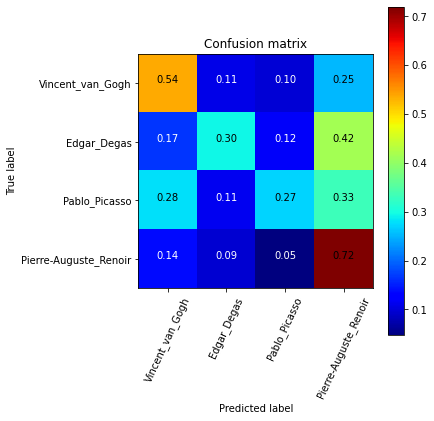

In [33]:
# load
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.3),
               nn.Linear(128, num_artists)).to(device)
model.load_state_dict(torch.load('./resnet50_4.h5'))

model.eval()

y_test=torch.tensor([]).to(device)
test_preds=torch.tensor([]).to(device)

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    y_test=torch.cat((y_test,labels),0)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_preds=torch.cat((test_preds,preds),0)
    
score = accuracy_score(y_test.cpu().numpy(), test_preds.cpu().numpy())
print(score)

plot_confuse(y_test.cpu(), test_preds.cpu(), artist_dict)

## Evaluate on Generated Images

0.39671931956257594


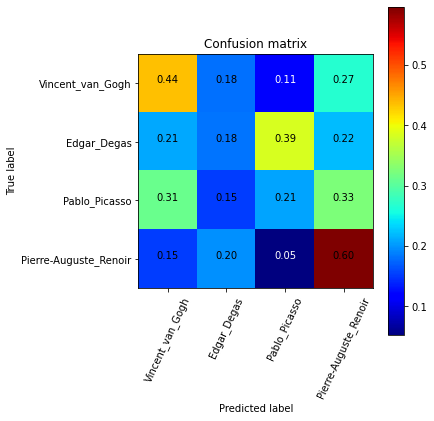

In [55]:
# load
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Dropout(0.3),
               nn.Linear(128, num_artists)).to(device)
model.load_state_dict(torch.load('./resnet50_4.h5'))

model.eval()

y_test=torch.tensor([]).to(device)
test_preds=torch.tensor([]).to(device)

generated_dir = './images_generated'
image_datasets = {
    'generated': 
    datasets.ImageFolder(generated_dir, data_transforms['transform']),
}

dataloaders = {
    'generated':
    torch.utils.data.DataLoader(image_datasets['generated'],
                                batch_size=128,
                                shuffle=False)}

for inputs, labels in dataloaders['generated']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    y_test=torch.cat((y_test,labels),0)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_preds=torch.cat((test_preds,preds),0)
    
score = accuracy_score(y_test.cpu().numpy(), test_preds.cpu().numpy())
plot_confuse(y_test.cpu(), test_preds.cpu(), artist_dict)
print(score)